# MLDA benchmarks and tuning demonstration

The Multi-Level Delayed Acceptance MCMC algorithm (MLDA) proposed in [1] is based on the idea of running a hierarchy of MCMC chains at different model coarseness levels (where the coarser the model, the less accurate the approximation to the fine model). The samples generated by a chain are used to propose samples for the level above. This can improve effective sample size in the fine chain in models that have the ability to be represented with varying coarseness.

This notebook compares the performance of MLDA to other PyMC3 algorithms (Metropolis, DEMCMC, DEMCMC-Z), using a groundwater flow inverse model. We demonstrate how the algorithms' performances compare when the dimension, resolution and lambda_cov parameter of the model changes.

The second part of the notebook explains the tuning parameters of MLDA and how they should be selected.

## 1. Benchmarks

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import pathlib
import ipywidgets
import time
import fastprogress
import pymc3 as pm
import arviz as az
import sys
sys.path.insert(1, 'mlda/')
import os
import theano.tensor as tt
from Model import Model, model_wrapper, project_eigenpairs
from itertools import product

os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Set environmental variable
%matplotlib inline

### Setting constants

Here, we set some constants which are used for all combinations of model/algorithm.

In [4]:
# Set random field parameters
field_mean = 0
field_stdev = 1

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = False

# Set the sigma for inference
sigma = 0.01

# Data generation seed
data_seed = 12345

# Sampling seed
sampling_seed = 12345

# Datapoints list
points_list = [0.1, 0.3, 0.5, 0.7, 0.9]

### Theano Op for likelihood

Here, we define a Theano Op which makes use of external code to calculate the likelihood of the model

In [5]:
# Use a Theano Op along with the code within ./mlda to construct the likelihood

def my_loglik(my_model, theta, datapoints, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    output = model_wrapper(my_model, theta, datapoints)
    return - (0.5 / sigma ** 2) * np.sum((output - data) ** 2)

class LogLike(tt.Op):
    """
    Theano Op that wraps the log-likelihood computation, necessary to
    pass "black-box" fenics code into pymc3.
    Based on the work in:
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model and a model object) and returning a single "scalar"
    # value (the log-likelihood)
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        my_model:
            A Model object (defined in model.py) that contains the parameters
            and functions of out model.
        loglike:
            The log-likelihood function we've defined, in this example it is
            my_loglik.
        data:
            The "observed" data that our log-likelihood function takes in. These
            are the true data generated by the finest model in this example.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.my_model = my_model
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.my_model, theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood


### Model and inference functions
The functions below construct a model with the provided parameters and run the selected MCMC method on PyMC3. The resulting trace is saved with ArviZ.

If the saved trace is already found, it is loaded from disk.

In [11]:
def get_model(resolutions, field_mean, field_stdev, 
              lamb_cov, nparam, data_seed, 
              points_list, sigma):
    """Generate a model, coarse models and the true parameter vector, given the inputs"""
    
    # Note this can take several minutes for large resolutions
    my_models = []
    for r in resolutions:
        my_models.append(Model(r, field_mean, field_stdev, nparam, lamb_cov))

    # Project eignevactors from fine model to all coarse models
    for i in range(len(my_models[:-1])):
        project_eigenpairs(my_models[-1], my_models[i])
        
    # Solve finest model as a test and plot transmissivity field and solution
    np.random.seed(data_seed)
    my_models[-1].solve()    

    # Save true parameters of finest model
    true_parameters = my_models[-1].random_process.parameters    
    
    # Define the sampling points.
    x_data = y_data = np.array(points_list)
    datapoints = np.array(list(product(x_data, y_data)))

    # Get data from the sampling points and perturb it with some noise.
    noise = np.random.normal(0, 0.001, len(datapoints))

    # Generate data from the finest model for use in pymc3 inference - these data are used in all levels
    data = model_wrapper(my_models[-1], true_parameters, datapoints) + noise
    
    # create Theano Ops to wrap likelihoods of all model levels and store them in list
    logl = []
    for m in my_models:
        logl.append(LogLike(m, my_loglik, data, datapoints, sigma))
        
    # Set up models in pymc3 for each level - excluding finest model level
    coarse_models = []
    for j in range(len(my_models) - 1):
        with pm.Model() as cmodel:
            # uniform priors on parameters
            parameters = []
            for i in range(nparam):
                parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

            # convert m and c to a tensor vector
            theta = tt.as_tensor_variable(parameters)

            # use a Potential for the likelihood
            ll = logl[j]
            pm.Potential('likelihood', ll(theta))

        coarse_models.append(cmodel)
      

    with pm.Model() as model:
        # Uniform priors on parameters
        parameters = []
        start = dict()
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # Convert m and c to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        ## use a Potential for the likelihood
        pm.Potential('likelihood', logl[-1](theta))
        
    return model, coarse_models, true_parameters

In [12]:
def run_setting(D, resolutions, lamb_cov, N_tune, N_draws, N_chains, algorithm, 
                                           model, coarse_models, true_parameters, tune, tune_interval, 
                                           blocked, nsub, discard_tuning, sampling_seed, data_seed, init):
    """Run inference on the given model using the selected algorithm and parameters, return the trace"""    
    
    savename = f'{algorithm}_{D}_{resolutions}_{lamb_cov}_{N_tune}_{N_draws}_{N_chains}_{tune}_{tune_interval}_{blocked}_{nsub}_{discard_tuning}_{sampling_seed}_{data_seed}_{init}.nc'
    print(f'Scenario filename: {savename}')
    if not pathlib.Path(savename).exists():        
        with model:
            if algorithm == 'metropolis':
                step = pm.Metropolis(tune=tune, tune_interval=tune_interval, blocked=blocked)
            elif algorithm == 'demcmc':
                step = pm.DEMetropolis(tune='scaling', tune_interval=tune_interval)
            elif algorithm == 'demcmcz':
                step = pm.DEMetropolisZ(tune_interval=tune_interval)
            elif algorithm == 'mlda':
                step = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                               tune=tune, tune_interval=tune_interval, base_blocked=blocked)
            t_start = time.time()
            if init:
                start = dict()
                for i, p in enumerate(true_parameters):
                    start['theta_' + str(i)] = p
                trace = pm.sample(
                    tune=N_tune, draws=N_draws, chains=N_chains,
                    step=step, start=start,
                    discard_tuned_samples=discard_tuning,
                    random_seed=sampling_seed
                )
            else:
                trace = pm.sample(
                    tune=N_tune, draws=N_draws, chains=N_chains,
                    step=step,
                    discard_tuned_samples=discard_tuning,
                    random_seed=sampling_seed
                )
            t = time.time() - t_start
        trace = az.from_pymc3(trace)
        trace.sample_stats.attrs['t_sampling'] = t
        trace.to_netcdf(savename)
    else:
        trace = az.from_netcdf(savename)
        t = float(trace.sample_stats.t_sampling)
    return t, trace

### Running the Benchmark Scenarios
Here a variety of different scenarios is computed and the results are aggregated in a multi-indexed DataFrame.

In [13]:
df_results = pd.DataFrame(columns='algorithm,D,resolutions,lamb_cov,N_tune,N_draws,N_chains,blocked,nsub,t,trace'.split(','))
df_results = df_results.set_index('algorithm,D,resolutions,lamb_cov,N_tune,N_draws,N_chains,blocked,nsub'.split(','))

for init in [True]:
    for D in [2, 4]:
        
        if D == 2:
            N_tune = 1500
            N_draws = 1500
        else:
            N_tune = 5000
            N_draws = 5000
            
        for i, resolutions in {2: [(30, 30), (120, 120)],
                               3: [(50, 50), (100, 100)]}.items():
            for lamb_cov in [0.1, 5.0]:                
                model, coarse_models, true_parameters = get_model(resolutions, field_mean, field_stdev,
                                                                  lamb_cov, D, data_seed, 
                                                                  points_list, sigma)
                for algorithm in ['mlda']:
                    for blocked in [False]:
                        for nsub in [10]:                            
                            for N_chains in [4]:
                                t, trace = run_setting(D, resolutions, lamb_cov, N_tune, N_draws, N_chains, algorithm, 
                                                       model, coarse_models, true_parameters, tune, tune_interval, 
                                                       blocked, nsub, discard_tuning, sampling_seed, data_seed, init)                                
                                df_results.loc[(algorithm, D, i, lamb_cov, N_tune, N_draws, N_chains, blocked, nsub)] = (t, trace)

                for algorithm in ['metropolis']:
                    for blocked in [False]:
                        for nsub in [0]:                            
                            for N_chains in [4]:
                                t, trace = run_setting(D, resolutions, lamb_cov, N_tune, N_draws, N_chains, algorithm, 
                                                       model, coarse_models, true_parameters, tune, tune_interval, 
                                                       blocked, nsub, discard_tuning, sampling_seed, data_seed, init)                                
                                df_results.loc[(algorithm, D, i, lamb_cov, N_tune, N_draws, N_chains, blocked, nsub)] = (t, trace)

                for algorithm in ['demcmc', 'demcmcz']:
                    for blocked in [False]:
                        for nsub in [0]:                            
                            for N_chains in [4]:
                                t, trace = run_setting(D, resolutions, lamb_cov, N_tune, N_draws, N_chains, algorithm, 
                                                       model, coarse_models, true_parameters, tune, tune_interval, 
                                                       blocked, nsub, discard_tuning, sampling_seed, data_seed, init)                                
                                df_results.loc[(algorithm, D, i, lamb_cov, N_tune, N_draws, N_chains, blocked, nsub)] = (t, trace)

Scenario filename: mlda_2_[(30, 30), (120, 120)]_0.1_1500_1500_4_True_100_False_10_False_12345_12345_True.nc
Scenario filename: metropolis_2_[(30, 30), (120, 120)]_0.1_1500_1500_4_True_100_False_0_False_12345_12345_True.nc
Scenario filename: demcmc_2_[(30, 30), (120, 120)]_0.1_1500_1500_4_True_100_False_0_False_12345_12345_True.nc
Scenario filename: demcmcz_2_[(30, 30), (120, 120)]_0.1_1500_1500_4_True_100_False_0_False_12345_12345_True.nc
Scenario filename: mlda_2_[(30, 30), (120, 120)]_5.0_1500_1500_4_True_100_False_10_False_12345_12345_True.nc
Scenario filename: metropolis_2_[(30, 30), (120, 120)]_5.0_1500_1500_4_True_100_False_0_False_12345_12345_True.nc
Scenario filename: demcmc_2_[(30, 30), (120, 120)]_5.0_1500_1500_4_True_100_False_0_False_12345_12345_True.nc
Scenario filename: demcmcz_2_[(30, 30), (120, 120)]_5.0_1500_1500_4_True_100_False_0_False_12345_12345_True.nc
Scenario filename: mlda_2_[(50, 50), (100, 100)]_0.1_1500_1500_4_True_100_False_10_False_12345_12345_True.nc
Sce

In [14]:
pd.set_option('display.max_rows', 100)
df_results

,,,,,,,,,t,trace
algorithm,D,resolutions,lamb_cov,N_tune,N_draws,N_chains,blocked,nsub,,
mlda,2,2,0.1,1500,1500,4,False,10,1389.478221,Inference data with groups:\n\t> posterior\n\t...
metropolis,2,2,0.1,1500,1500,4,False,0,1274.983871,Inference data with groups:\n\t> posterior\n\t...
demcmc,2,2,0.1,1500,1500,4,False,0,1864.953730,Inference data with groups:\n\t> posterior\n\t...
demcmcz,2,2,0.1,1500,1500,4,False,0,620.677846,Inference data with groups:\n\t> posterior\n\t...
mlda,2,2,5.0,1500,1500,4,False,10,1019.688392,Inference data with groups:\n\t> posterior\n\t...
metropolis,2,2,5.0,1500,1500,4,False,0,961.378178,Inference data with groups:\n\t> posterior\n\t...
demcmc,2,2,5.0,1500,1500,4,False,0,1533.069393,Inference data with groups:\n\t> posterior\n\t...
demcmcz,2,2,5.0,1500,1500,4,False,0,479.296644,Inference data with groups:\n\t> posterior\n\t...
mlda,2,3,0.1,1500,1500,4,False,10,1510.396066,Inference data with groups:\n\t> posterior\n\t...


### Analyzing the traces
From the traces, we need to compute the absolute $N_{eff}$, $N_{eff}$ per second and the $\hat{R}$.

In [90]:
df_temp = df_results.reset_index(['N_tune', 'N_draws'])

df_temp['trace'] = [
    az.from_pymc3(trace) if isinstance(trace, pm.backends.base.MultiTrace) else trace
    for trace in df_temp.trace
]
df_temp['N_samples'] = [
    row.N_draws * row.Index[2]
    for row in df_temp.itertuples()
]

df_temp['ess_theta_0'] = [
    float(az.ess({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_0)
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))
]
df_temp['ess_theta_1'] = [
    float(az.ess({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_1) if row.Index[1] > 1 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))     
]
df_temp['ess_theta_2'] = [
    float(az.ess({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_2) if row.Index[1] > 2 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))     
]
df_temp['ess_theta_3'] = [
    float(az.ess({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_3) if row.Index[1] > 3 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))     
]

df_temp['ess_rate_theta_0'] = [
    row.ess_theta_0 / (row.t)
    for row in df_temp.itertuples()
]
df_temp['ess_rate_theta_1'] = [
    row.ess_theta_1 / (row.t) if row.Index[1] > 1 else None
    for row in df_temp.itertuples()
]
df_temp['ess_rate_theta_2'] = [
    row.ess_theta_2 / (row.t) if row.Index[1] > 2 else None
    for row in df_temp.itertuples()
]
df_temp['ess_rate_theta_3'] = [
    row.ess_theta_3 / (row.t) if row.Index[1] > 3 else None
    for row in df_temp.itertuples()
]

df_temp['r_hat_0'] = [
    float(az.rhat({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_0) if row.Index[1] > 0 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))
]
df_temp['r_hat_1'] = [
    float(az.rhat({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_1) if row.Index[1] > 1 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))
]
df_temp['r_hat_2'] = [
    float(az.rhat({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_2) if row.Index[1] > 2 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))
]
df_temp['r_hat_3'] = [
    float(az.rhat({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_3) if row.Index[1] > 3 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))
]

df_temp = df_temp.sort_index(level=['D', 'resolutions', 'lamb_cov','N_chains', 'blocked', 'nsub','algorithm'])

### Results

Here, we show the effective sample size per second for each combination. MLDA is usually the fastest method. DEMCMC-Z is faster in some cases. Note that all runs have been done without tuning the algorithm parameters. The performance of all methods might change if we properly tune them but this test is just to demonstrate out of the box performance.

In [95]:
df_temp[["ess_rate_theta_0", "ess_rate_theta_1", "ess_rate_theta_2", "ess_rate_theta_3"]]

,,,,,,,ess_rate_theta_0,ess_rate_theta_1,ess_rate_theta_2,ess_rate_theta_3
algorithm,D,resolutions,lamb_cov,N_chains,blocked,nsub,,,,
demcmc,2,2,0.1,4,False,0,0.184663,0.188431,NaN,NaN
demcmcz,2,2,0.1,4,False,0,1.020549,1.311071,NaN,NaN
metropolis,2,2,0.1,4,False,0,0.798405,0.891589,NaN,NaN
mlda,2,2,0.1,4,False,10,4.098620,3.979279,NaN,NaN
demcmc,2,2,5.0,4,False,0,0.375166,0.420770,NaN,NaN
demcmcz,2,2,5.0,4,False,0,1.748500,1.791761,NaN,NaN
metropolis,2,2,5.0,4,False,0,1.172936,0.997540,NaN,NaN
mlda,2,2,5.0,4,False,10,5.432259,5.133738,NaN,NaN
demcmc,2,3,0.1,4,False,0,0.518644,0.239316,NaN,NaN


Most runs have R_hat very close to 1.0, except for a few cases of Metropolis and DEMCMC which do not converge well.

In [96]:
df_temp[['r_hat_0', 'r_hat_1', 'r_hat_2', 'r_hat_3']]

,,,,,,,r_hat_0,r_hat_1,r_hat_2,r_hat_3
algorithm,D,resolutions,lamb_cov,N_chains,blocked,nsub,,,,
demcmc,2,2,0.1,4,False,0,1.003380,1.015242,NaN,NaN
demcmcz,2,2,0.1,4,False,0,1.005411,1.002788,NaN,NaN
metropolis,2,2,0.1,4,False,0,1.014821,1.004880,NaN,NaN
mlda,2,2,0.1,4,False,10,0.999833,0.999872,NaN,NaN
demcmc,2,2,5.0,4,False,0,1.010244,1.008778,NaN,NaN
demcmcz,2,2,5.0,4,False,0,1.008737,1.005063,NaN,NaN
metropolis,2,2,5.0,4,False,0,1.003609,1.003136,NaN,NaN
mlda,2,2,5.0,4,False,10,1.000299,1.000076,NaN,NaN
demcmc,2,3,0.1,4,False,0,1.010325,1.023111,NaN,NaN


## 2. MLDA tuning
Here we do a few extra MLDA runs using the same model but with different subsampling rates. We will demonstrate how performance changes.

In [167]:
df_tuning = pd.DataFrame(columns='algorithm,D,resolutions,lamb_cov,N_tune,N_draws,N_chains,blocked,nsub,t,trace'.split(','))
df_tuning = df_tuning.set_index('algorithm,D,resolutions,lamb_cov,N_tune,N_draws,N_chains,blocked,nsub'.split(','))

for init in [True]:
    for D in [2]:
        N_tune = 1000
        N_draws = 1000
            
        for i, resolutions in {0: [(10, 10), (40, 40)]}.items():
            for lamb_cov in [0.05]:                
                model, coarse_models, true_parameters = get_model(resolutions, field_mean, field_stdev,
                                                                  lamb_cov, D, data_seed, 
                                                                  points_list, sigma)
                for algorithm in ['mlda']:
                    for blocked in [False]:
                        for nsub in [1, 2, 5, 10, 20, 30]:                            
                            for N_chains in [4]:
                                t, trace = run_setting(D, resolutions, lamb_cov, N_tune, N_draws, N_chains, algorithm, 
                                                       model, coarse_models, true_parameters, tune, tune_interval, 
                                                       blocked, nsub, discard_tuning, sampling_seed, data_seed, init)                                
                                df_tuning.loc[(algorithm, D, i, lamb_cov, N_tune, N_draws, N_chains, blocked, nsub)] = (t, trace)

Scenario filename: mlda_2_[(10, 10), (40, 40)]_0.05_1000_1000_4_True_100_False_1_False_12345_12345_True.nc
Scenario filename: mlda_2_[(10, 10), (40, 40)]_0.05_1000_1000_4_True_100_False_2_False_12345_12345_True.nc
Scenario filename: mlda_2_[(10, 10), (40, 40)]_0.05_1000_1000_4_True_100_False_5_False_12345_12345_True.nc
Scenario filename: mlda_2_[(10, 10), (40, 40)]_0.05_1000_1000_4_True_100_False_10_False_12345_12345_True.nc
Scenario filename: mlda_2_[(10, 10), (40, 40)]_0.05_1000_1000_4_True_100_False_20_False_12345_12345_True.nc
Scenario filename: mlda_2_[(10, 10), (40, 40)]_0.05_1000_1000_4_True_100_False_30_False_12345_12345_True.nc


In [168]:
df_temp = df_tuning.reset_index(['N_tune', 'N_draws'])

df_temp['trace'] = [
    az.from_pymc3(trace) if isinstance(trace, pm.backends.base.MultiTrace) else trace
    for trace in df_temp.trace
]
df_temp['N_samples'] = [
    row.N_draws * row.Index[2]
    for row in df_temp.itertuples()
]

df_temp['ess_theta_0'] = [
    float(az.ess({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_0)
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))
]
df_temp['ess_theta_1'] = [
    float(az.ess({
        k : v[:,row.N_tune:]
        for k, v in row.trace.posterior.items()
    }).theta_1) if row.Index[1] > 1 else None
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))     
]

df_temp['ess_rate_theta_0'] = [
    row.ess_theta_0 / (row.t)
    for row in df_temp.itertuples()
]
df_temp['ess_rate_theta_1'] = [
    row.ess_theta_1 / (row.t) if row.Index[1] > 1 else None
    for row in df_temp.itertuples()
]

df_temp = df_temp.sort_index(level=['D', 'resolutions', 'lamb_cov','N_chains', 'blocked', 'nsub','algorithm'])

These plots show how runtime, $N_{eff}$ (ESS) and $N_{eff}$ rate (ESS/sec) change when we change the subsampling rate. 
You can see that runtime increases almost linearly and ESS does not increase after a certain point.

In terms of performance (ESS/sec), setting it to 5 gives the best performance. It is worth doing some short trial runs and pick a reasonably good subsampling rate before you do a long run.

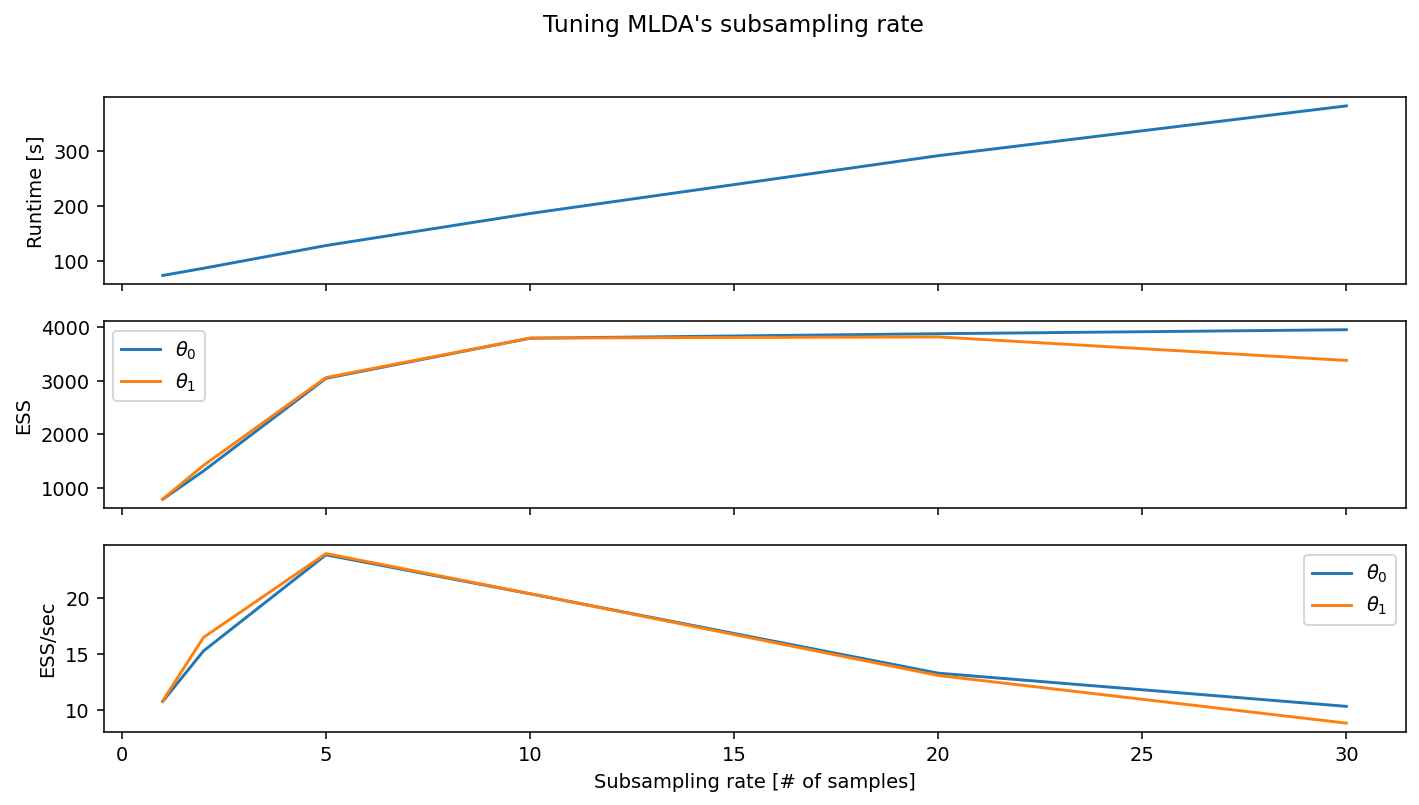

In [146]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, dpi=140, sharex=True, figsize=(12,6))
fig.suptitle('Tuning MLDA\'s subsampling rate')

df = df_temp.loc[(algorithm, D)].reset_index()
ax1.plot(
    df.nsub,
    df.t
)
ax2.plot(
    df.nsub,
    df.ess_theta_0,
    label='$\\theta_0$'
)
ax2.plot(
    df.nsub,
    df.ess_theta_1,
    label='$\\theta_1$'
)
ax3.plot(
    df.nsub,
    df.ess_rate_theta_0,
    label='$\\theta_0$'
)
ax3.plot(
    df.nsub,
    df.ess_rate_theta_1,
    label='$\\theta_1$'
)

ax2.legend()
ax3.legend()
ax1.set_ylabel('Runtime [s]')
ax2.set_ylabel('ESS')
ax3.set_ylabel('ESS/sec')
ax3.set_xlabel('Subsampling rate [# of samples]')
plt.show()

Generally, the optimal subsampling rate depends on the complexity of the fine posterior. The more complex the posterior, the more samples are needed to generate a decent proposal. The reason is that the MLDA sampler is based on the assumption that the coarse proposal samples (i.e. the samples sent from the coarse chain to the fine one) are independent from each other. In order to generate independent samples, it is necessary to run the coarse chain for an adequate number of iterations to get rid of autocorrelation. The more complex the posterior the more iterations are needed and thus a larger subsampling rate.

Note that in cases where you have more than one coarse model/level, MLDA allows you to choose a different subsampling rate for each coarse level (as a list of integers when you instantiate the stepper).